In [12]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import re
from dateparser import parse
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from transformers import AutoTokenizer, AutoModel
import shap
from sklearn.decomposition import PCA
import plotly.express as px
from captum.attr import LayerIntegratedGradients, LayerConductance, GradientShap, IntegratedGradients
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [2]:
# Load the Indonesian BERT model and tokenizer
tokenizer_indo = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model_indo = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Load the BERT model and tokenizer for English text
tokenizer_eng = AutoTokenizer.from_pretrained("bert-base-uncased")
model_eng = AutoModel.from_pretrained("bert-base-uncased")

# Load your tweet data and survey data
tweet_data = pd.read_csv("Prabowo_All2.csv", delimiter='\t', header=None, names=['data'])
tweet_data = tweet_data['data'].str.split(';', expand=True)
tweet_data.columns = ['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count',
                      'retweet_count', 'favorite_count', 'lang', 'user_id_str',
                      'conversation_id_str', 'username', 'tweet_url']

# Load your survey data
survey_data = pd.read_excel('Electionforcode_Prabowo3.xlsx')

# Preprocess tweet text (you may need to adjust the preprocessing)
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Preprocess tweet data
tweet_data['full_text'] = tweet_data['full_text'].astype(str)
tweet_data['cleaned_full_text'] = tweet_data['full_text'].apply(preprocess_text)

# Convert 'created_at' to datetime format
tweet_data['date'] = pd.to_datetime(tweet_data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
tweet_data = tweet_data.dropna(subset=['date'])

# Preprocess survey data
file_data = pd.read_excel('Phenomena2.xlsx')
file_data['cleaned_Phenomenon'] = file_data['Phenomenon'].astype(str).apply(preprocess_text)
file_data['date'] = pd.to_datetime(file_data['Date'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
file_data = file_data.dropna(subset=['date'])

# Lists to store BERT embeddings and survey results
bert_results = []
survey_results = []

In [3]:
# Create a loop to process survey data and extract BERT embeddings with an additional Events feature
for index, row in survey_data.iterrows():
    # Define the date range from your survey data and process it
    date_range = row['Date Range']
    date_parts = date_range.split('-')
    start_date_str = date_parts[0].strip()
    end_date_str = date_parts[1].strip()
    start_date = parse(start_date_str)
    end_date = parse(end_date_str)
    
    # Define the tweet date range
    tweet_start_date = start_date - timedelta(days=7)
    tweet_end_date = end_date + timedelta(days=7)
    
    # Filter tweets within the date range
    tweets_in_interval = tweet_data[(tweet_data['date'] >= tweet_start_date) & (tweet_data['date'] <= tweet_end_date)]
    
    # Extract cleaned text as a list
    cleaned_texts_indo = tweets_in_interval['cleaned_full_text'].astype(str).tolist()
    
    # Tokenize and get BERT embeddings for each tweet in the interval
    tweet_embeddings_indo = []
    for text in cleaned_texts_indo:
        inputs = tokenizer_indo(text, return_tensors="pt", padding=True, truncation=False)
        with torch.no_grad():
            outputs = model_indo(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over tokens
        tweet_embeddings_indo.append(embeddings)
    
    # Calculate the average BERT embedding for the tweets in the interval
    avg_bert_embedding_indo = torch.mean(torch.stack(tweet_embeddings_indo), dim=0).numpy()
    
    # Get the one-hot encoded features for the "Polling firm"
    polling_firm_features = row.filter(like='polling_').values
    
    # Get the 'Numbers of Candidate' feature
    numbers_of_candidate_value = row['Numbers of Candidate']
    
    # Define the date range for Events
    event_start_date = start_date - timedelta(days=17)
    event_end_date = end_date 
    
    # Filter Events within the date range
    events_in_interval = file_data[(file_data['date'] >= event_start_date) & (file_data['date'] <= event_end_date)]
    
    # Extract cleaned text as a list for Events
    cleaned_texts_eng = events_in_interval['cleaned_Phenomenon'].astype(str).tolist()
    
    # Tokenize and get BERT embeddings for each Event in the interval
    event_embeddings_eng = []
    for text in cleaned_texts_eng:
        inputs = tokenizer_eng(text, return_tensors="pt", padding=True, truncation=False)
        with torch.no_grad():
            outputs = model_eng(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over tokens
        event_embeddings_eng.append(embeddings)
    
    # Calculate the average BERT embedding for the Events in the interval
    avg_bert_embedding_eng = torch.mean(torch.stack(event_embeddings_eng), dim=0).numpy()
    
    # Reshape the 1D arrays to have the same shape as avg_bert_embedding
    polling_firm_features = polling_firm_features.reshape(1, -1)
    numbers_of_candidate_value = np.array([numbers_of_candidate_value]).reshape(1, -1)
    
    # Concatenate the arrays for both tweets and Events
    combined_features = np.concatenate((avg_bert_embedding_indo, avg_bert_embedding_eng, polling_firm_features, numbers_of_candidate_value), axis=1)
    
    # Append the results to the list
    bert_results.append(combined_features)
    survey_results.append(row)

bert_results = np.array(bert_results)
survey_results = np.array(survey_results)

In [4]:
# Convert BERT embeddings to NumPy array
X = bert_results
y = survey_results[:, 1]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1) 
# Create and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train_flat, y_train)

X_test_flat = X_test.reshape(X_test.shape[0], -1) 
# Make predictions
y_pred = rf_model.predict(X_test_flat)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 0.038858946236559166
Mean Squared Error (MSE): 0.0028195271925304678
R-squared (R2) Score: 0.6731742005027677


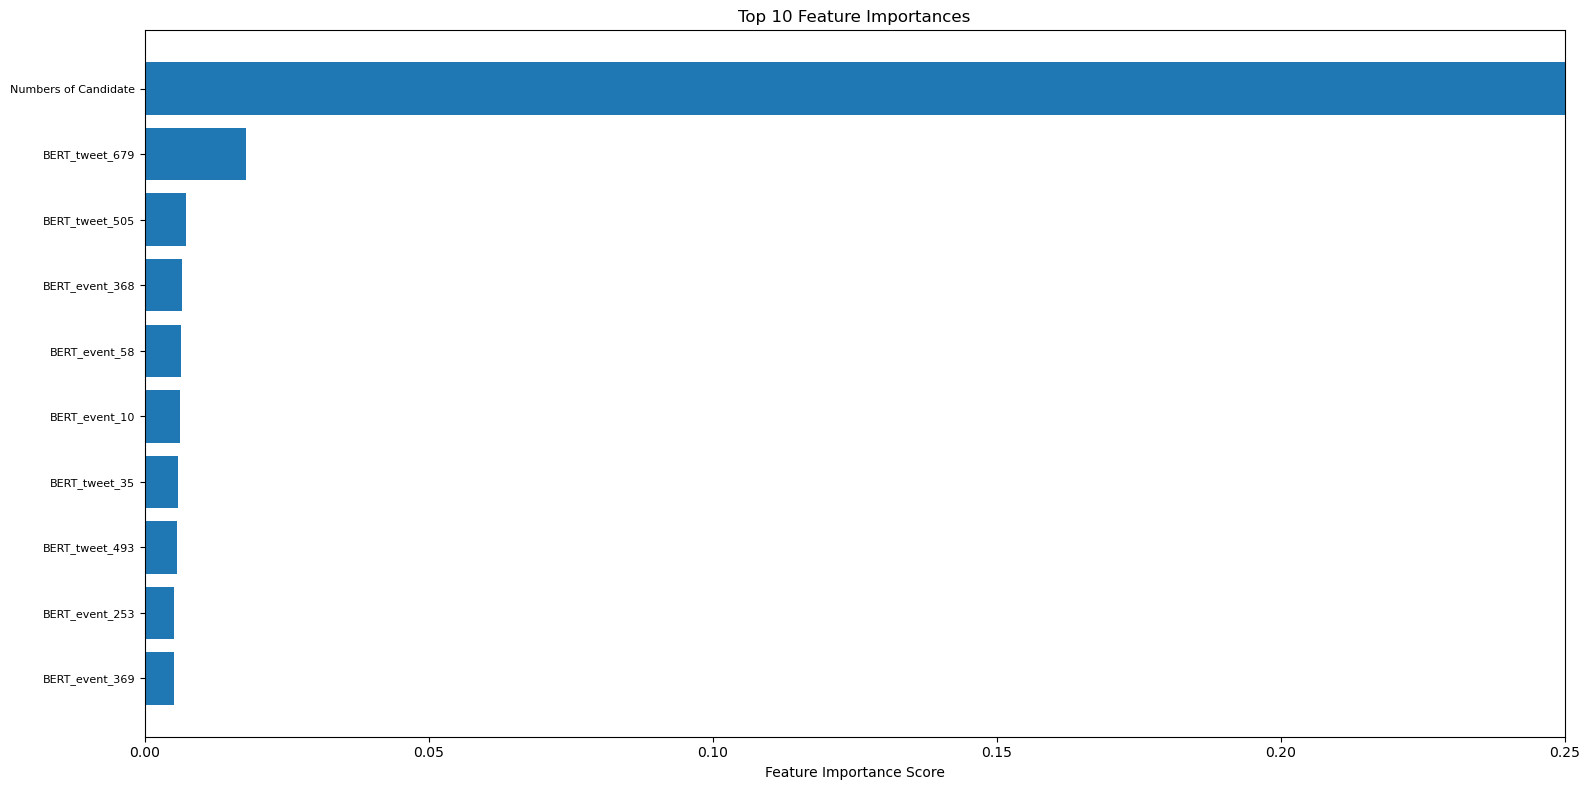

In [28]:
# Get feature names for BERT embeddings
bert_feature_names_eng = [f"BERT_event_{i}" for i in range(avg_bert_embedding_eng.shape[1])]
bert_feature_names_indo = [f"BERT_tweet_{i}" for i in range(avg_bert_embedding_indo.shape[1])]

# Combine all feature names
all_feature_names = bert_feature_names_eng + bert_feature_names_indo + survey_data.filter(like="polling_").columns.tolist() + ["Numbers of Candidate"]

# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Limit the number of features to display
num_features_to_display = 10

# Get the top feature names and importances
top_feature_names = np.array(all_feature_names)[indices][:num_features_to_display]
top_importances = importances[indices][:num_features_to_display]

# Plot the top feature importances
plt.figure(figsize=(16, 8))
plt.title("Top {} Feature Importances".format(num_features_to_display))
plt.barh(range(num_features_to_display), top_importances[::-1], align="center")  
plt.yticks(range(num_features_to_display), top_feature_names[::-1], fontsize=8)  
plt.xlabel("Feature Importance Score")
plt.xlim(0, 0.25)
plt.tight_layout()
plt.show()

In [8]:
# ElasticNet
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elasticnet_model.fit(X_train_flat, y_train)
y_pred_elasticnet = elasticnet_model.predict(X_test_flat)

# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)
y_pred_knn = knn_model.predict(X_test_flat)

In [9]:
# Evaluate the ElasticNet model
mae_elasticnet = mean_absolute_error(y_test, y_pred_elasticnet)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)

# Evaluate the K-Nearest Neighbors model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

In [10]:
# Print evaluation metrics for ElasticNet
print("ElasticNet - Mean Absolute Error (MAE):", mae_elasticnet)
print("ElasticNet - Mean Squared Error (MSE):", mse_elasticnet)
print("ElasticNet - R-squared (R2) Score:", r2_elasticnet)

# Print evaluation metrics for K-Nearest Neighbors
print("K-Nearest Neighbors - Mean Absolute Error (MAE):", mae_knn)
print("K-Nearest Neighbors - Mean Squared Error (MSE):", mse_knn)
print("K-Nearest Neighbors - R-squared (R2) Score:", r2_knn)

ElasticNet - Mean Absolute Error (MAE): 0.04246021781674438
ElasticNet - Mean Squared Error (MSE): 0.0033234515179630885
ElasticNet - R-squared (R2) Score: 0.6147617578131092
K-Nearest Neighbors - Mean Absolute Error (MAE): 0.04111870967741934
K-Nearest Neighbors - Mean Squared Error (MSE): 0.0026716928516129037
K-Nearest Neighbors - R-squared (R2) Score: 0.690310434120776


In [15]:
# Feature permutation for ElasticNet
elasticnet_perm_importance = permutation_importance(elasticnet_model, X_test_flat, y_test, n_repeats=30, random_state=42)
elasticnet_importance_scores = elasticnet_perm_importance.importances_mean

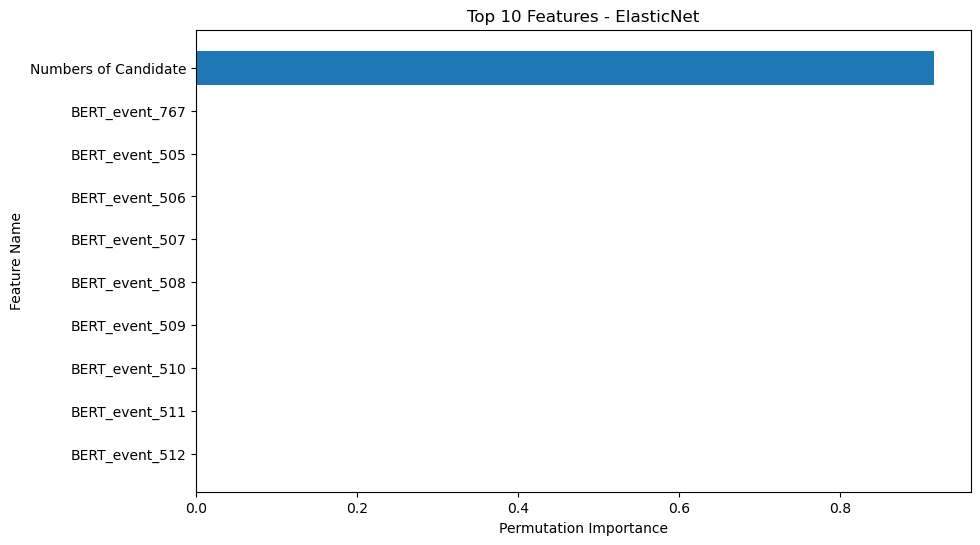

In [16]:
# Plot top 10 features for ElasticNet
top_features_elasticnet = np.argsort(elasticnet_importance_scores)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_elasticnet)), elasticnet_importance_scores[top_features_elasticnet], align='center')
plt.yticks(range(len(top_features_elasticnet)), [all_feature_names[i] for i in top_features_elasticnet])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Features - ElasticNet')
plt.show()

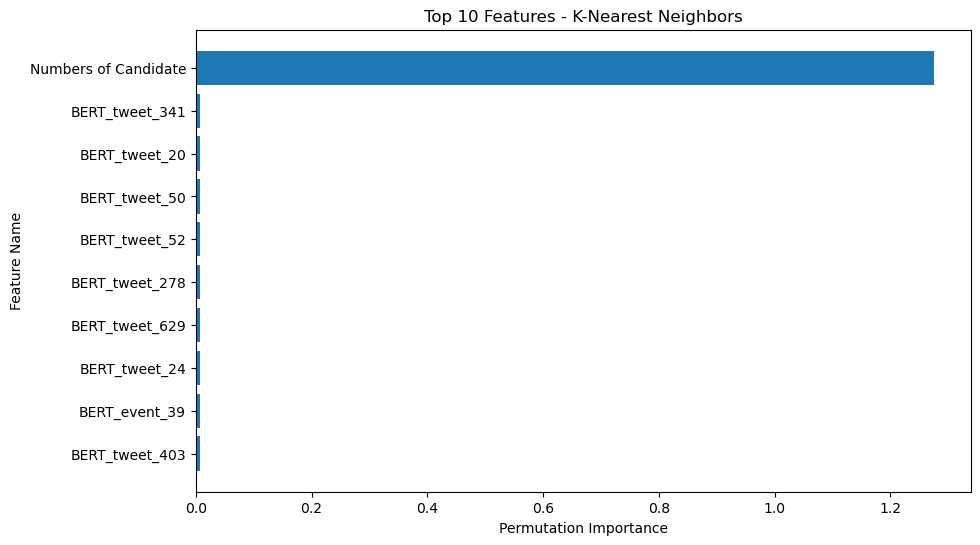

In [14]:
# Feature permutation for K-Nearest Neighbors
knn_perm_importance = permutation_importance(knn_model, X_test_flat, y_test, n_repeats=30, random_state=42)
knn_importance_scores = knn_perm_importance.importances_mean

# Plot top 10 features for K-Nearest Neighbors
top_features_knn = np.argsort(knn_importance_scores)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_knn)), knn_importance_scores[top_features_knn], align='center')
plt.yticks(range(len(top_features_knn)), [all_feature_names[i] for i in top_features_knn])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Features - K-Nearest Neighbors')
plt.show()

In [7]:
# Calculate NWI scores for the top-10 most important words
def calculate_nwi_for_word(model, X_test, y_test, word):
    neutral_word = tokenizer_indo.encode('neutral')[0]
    neutral_X_test = X_test.copy().astype(np.float32)  # Convert to float32

    for i in range(len(neutral_X_test)):
        for j in range(len(neutral_X_test[i])):
            if neutral_X_test[i][j] == tokenizer_indo.encode(word)[0]:
                neutral_X_test[i][j] = neutral_word

    # Get predictions using the RandomForestRegressor
    original_outputs = model.predict(X_test_flat)
    neutral_outputs = model.predict(neutral_X_test)

    nwi_score = np.mean(original_outputs - neutral_outputs)
    return nwi_score

top_n_words = []
for i in range(10):
    max_shap_value_index = np.argmax(shap_values[0])
    word = tokenizer_indo.decode(max_shap_value_index)
    top_n_words.append(word)

# Print the top-10 most important words and their NWI scores
print("\nTop-10 Most Important Words (NWI):")
for i, word in enumerate(top_n_words):
    nwi_score = calculate_nwi_for_word(rf_model, X_test_flat, y_test, word)
    print(f"{i+1}. {word}: {nwi_score}")


Top-10 Most Important Words (NWI):
1. ##ﺮ: 0.0
2. ##ﺮ: 0.0
3. ##ﺮ: 0.0
4. ##ﺮ: 0.0
5. ##ﺮ: 0.0
6. ##ﺮ: 0.0
7. ##ﺮ: 0.0
8. ##ﺮ: 0.0
9. ##ﺮ: 0.0
10. ##ﺮ: 0.0


In [8]:
print("\nShapley Values for Top-10 Words:")
for i, word in enumerate(top_n_words):
    shap_value = shap_values[0][i]
    print(f"{i+1}. {word}: {shap_value}")


Shapley Values for Top-10 Words:
1. ##ﺮ: -8.145334687109715e-05
2. ##ﺮ: -5.0611015244606284e-05
3. ##ﺮ: 0.00024300676915911773
4. ##ﺮ: -8.720772787001664e-06
5. ##ﺮ: -6.530803753491802e-07
6. ##ﺮ: 8.149571658723111e-07
7. ##ﺮ: 3.104412219856363e-06
8. ##ﺮ: 5.199523142107178e-08
9. ##ﺮ: -2.1860995647713334e-06
10. ##ﺮ: -0.00039128835039469384


In [14]:
# Create and train an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
xgb_model.fit(X_train_flat, y_train)
y_pred_xgb = xgb_model.predict(X_test_flat)

In [16]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\nXGBoost Model:")
print("Mean Absolute Error (MAE):", mae_xgb)
print("Mean Squared Error (MSE):", mse_xgb)
print("R-squared (R2) Score:", r2_xgb)


XGBoost Model:
Mean Absolute Error (MAE): 0.04641224
Mean Squared Error (MSE): 0.0034461468
R-squared (R2) Score: 0.6005395033620535


In [17]:
# Create and train a K-Nearest Neighbors Regressor model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)
y_pred_knn = knn_model.predict(X_test_flat)

In [18]:
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

In [19]:
print("\nK-Nearest Neighbors Model:")
print("Mean Absolute Error (MAE):", mae_knn)
print("Mean Squared Error (MSE):", mse_knn)
print("R-squared (R2) Score:", r2_knn)


K-Nearest Neighbors Model:
Mean Absolute Error (MAE): 0.041118708
Mean Squared Error (MSE): 0.0026716928
R-squared (R2) Score: 0.690310414700669


In [26]:
# Normalize the input features (BERT embeddings)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
# Convert BERT embeddings to NumPy array
X = bert_results
# Ensure that y_train is a NumPy array of a suitable data type (e.g., float32)
y_train = survey_results[:, 1].astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# Define the neural network model class
class BiggerNeuralNetwork(nn.Module):
    def __init__(self, input_dim, dropout_rate, hidden_dim1, hidden_dim2):
        super(BiggerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define hyperparameters for the grid search
dropout_rates = [0.1, 0.15, 0.2,  0.25, 0.3]
hidden_dim1_values = [160, 176, 192, 208, 224, 240, 256]
hidden_dim2_values = [128, 144, 160, 176, 192, 208, 224, 240, 256]
learning_rates = [0.001, 0.01, 0.1]

best_model = None
best_mse = float('inf')

# Perform grid search
for dropout_rate in dropout_rates:
    for hidden_dim1 in hidden_dim1_values:
        for hidden_dim2 in hidden_dim2_values:
            for learning_rate in learning_rates:
                # Create an instance of the neural network model
                input_dim = X_train_scaled.shape[1]
                bigger_nn_model = BiggerNeuralNetwork(input_dim, dropout_rate, hidden_dim1, hidden_dim2)

                # Convert the data to DataLoader for PyTorch
                train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
                train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

                # Define loss and optimizer
                criterion = nn.MSELoss()  # Mean Squared Error loss
                optimizer = optim.Adam(bigger_nn_model.parameters(), lr=learning_rate)

                # Training the neural network model
                num_epochs = 120
                for epoch in range(num_epochs):
                    bigger_nn_model.train()
                    optimizer.zero_grad()
                    outputs = bigger_nn_model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor.view(-1, 1))
                    loss.backward()
                    optimizer.step()

                # Make predictions using the trained neural network model
                bigger_nn_model.eval()
                with torch.no_grad():
                    y_pred_tensor = bigger_nn_model(X_test_tensor)
                y_pred_nn = y_pred_tensor.numpy().flatten()

                # Evaluate the neural network model
                mse_nn = mean_squared_error(y_test, y_pred_nn)

                # Check if this model has the best MSE so far
                if mse_nn < best_mse:
                    best_mse = mse_nn
                    best_model = bigger_nn_model

# Make predictions using the best model
best_model.eval()
with torch.no_grad():
    y_pred_tensor = best_model(X_test_tensor)
y_pred_nn = y_pred_tensor.numpy().flatten()

# Evaluate the best model
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Print the best hyperparameters and evaluation metrics
print("Best Hyperparameters:")
print("Dropout Rate:", best_model.dropout.p)
print("Hidden Dimension 1:", best_model.fc1.out_features)
print("Hidden Dimension 2:", best_model.fc2.out_features)
print("Learning Rate:", learning_rate)
print("Neural Network Mean Absolute Error (MAE):", mae_nn)
print("Neural Network Mean Squared Error (MSE):", mse_nn)
print("Neural Network R-squared (R2) Score:", r2_nn)

Best Hyperparameters:
Dropout Rate: 0.1
Hidden Dimension 1: 208
Hidden Dimension 2: 144
Learning Rate: 0.1
Neural Network Mean Absolute Error (MAE): 0.04459779
Neural Network Mean Squared Error (MSE): 0.0029880444
Neural Network R-squared (R2) Score: 0.6536405547628206


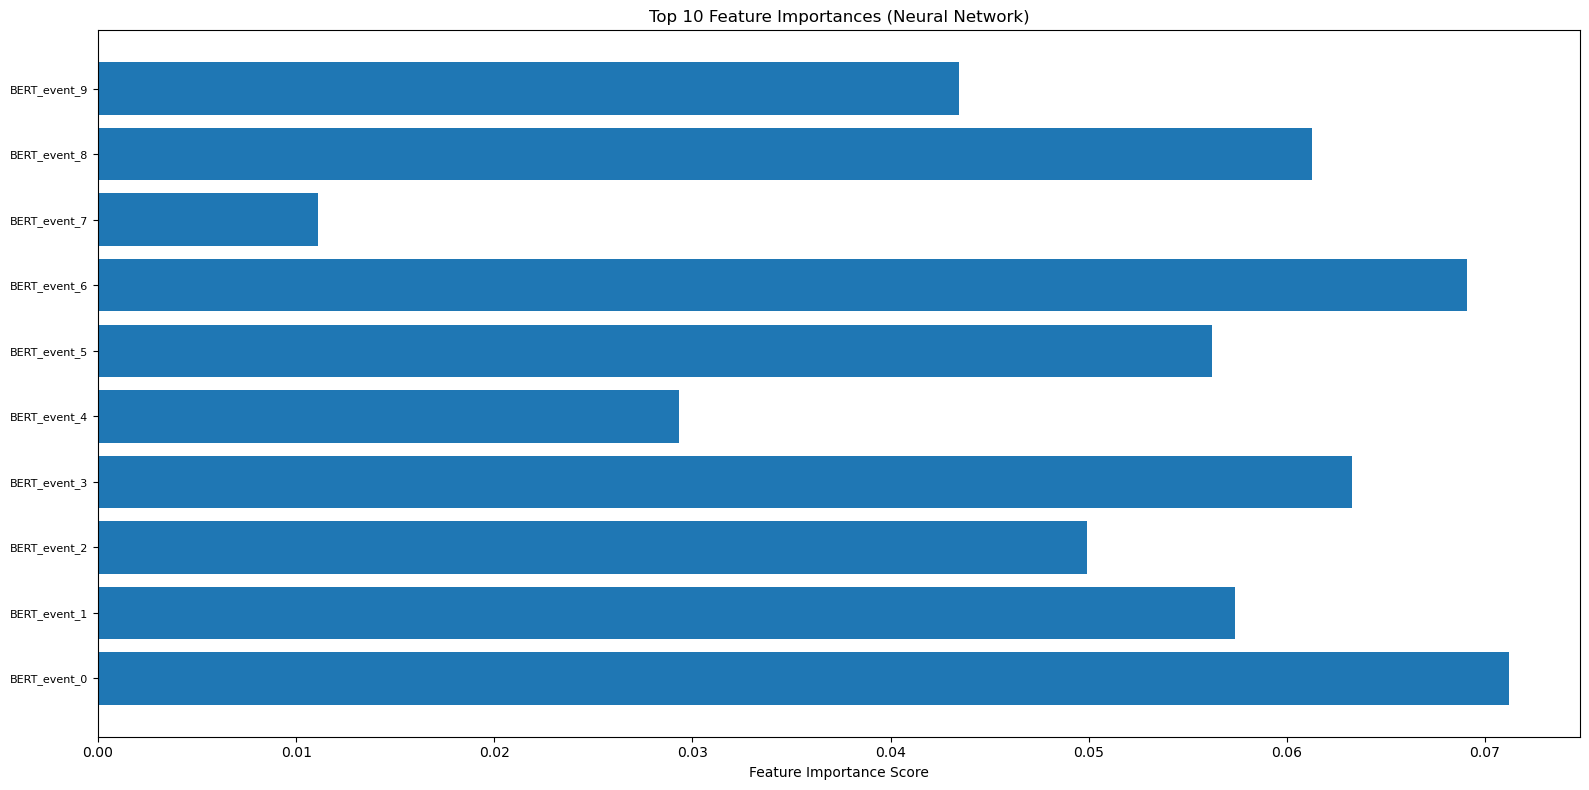

In [27]:
# Get the feature names for the input features
feature_names = all_feature_names  # Use the same feature names as in the Random Forest model

# Extract the absolute weights from the best neural network model
abs_weights = np.abs(best_model.fc1.weight.data.numpy().flatten())

# Limit the number of features to display
num_features_to_display_nn = 10

# Get the top feature names and weights
top_feature_names_nn = np.array(feature_names)[:num_features_to_display_nn]
top_weights_nn = abs_weights[:num_features_to_display_nn]

# Plot the top feature importances for the neural network
plt.figure(figsize=(16, 8))
plt.title("Top {} Feature Importances (Neural Network)".format(num_features_to_display_nn))
plt.barh(range(num_features_to_display_nn), top_weights_nn, align="center")
plt.yticks(range(num_features_to_display_nn), top_feature_names_nn, fontsize=8)  # Use yticks for y-axis labels
plt.xlabel("Feature Importance Score")  # Label for x-axis
plt.tight_layout()
plt.show()

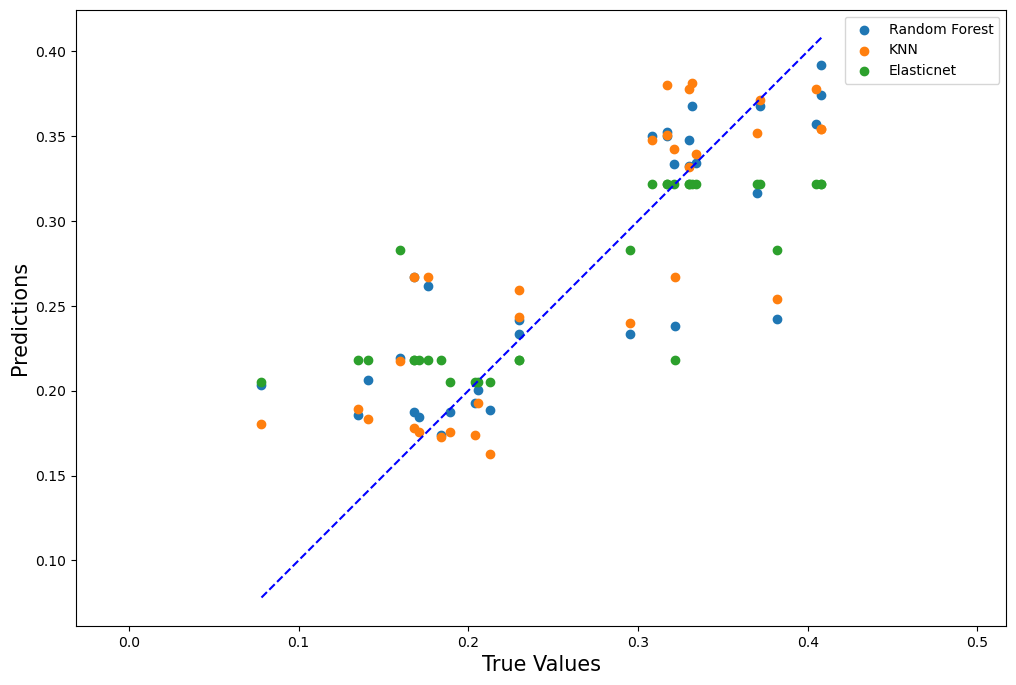

In [25]:
# Assuming you have predictions from Random Forest (y_pred_rf), XGBoost (y_pred_xgb), and LightGBM (y_pred_lgbm)
predictions = [y_pred, y_pred_knn, y_pred_elasticnet]
model_names = ['Random Forest', 'KNN', 'Elasticnet']

# Create a scatter plot for each model's predictions
plt.figure(figsize=(12, 8))

for i, model_pred in enumerate(predictions):
    plt.scatter(y_test, model_pred, label=model_names[i])


# Calculate the axis limits to ensure the diagonal line is shown
p1 = max([max(y_test)] + [max(pred) for pred in predictions])
p2 = min([min(y_test)] + [min(pred) for pred in predictions])

# Plot the diagonal line
plt.plot([p1, p2], [p1, p2], 'b--')

# Add labels and legend
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.legend()

# Show the plot
plt.show()